### Juan David Orjuela - Sofía Álvarez López

In [1]:
import random
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
#from keras import regularizers
from sklearn import preprocessing 
from scipy.stats import percentileofscore
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense #, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard

<h1 align='center'>Laboratorio 4: Machine Learning Techniques</h1>

## Problema 2

Para los bancos es sumamente importante reconocer transacciones fraudulentas con el objetivo de que los clientes no paguen por cosas que no compraron. Con respecto a lo anterior, se recogieron datos de más de 200 mil transacciones con un porcentaje de 0.172% de transacciones fraudulentas. Dada la baja cantidad de fraudes, se le pidió a ud que creara un modelo de inteligencia artificial para poder detectar este tipo de anomalías.

Fuente de Datos: https://www.kaggle.com/mlg-ulb/creditcardfraud


### Exploración de los datos

Kaggle nos informa que los datos corresponden a transacciones de tarjeta de crédito hechas durante dos días en Septiembre de 2013 por tarjetahabientes europeos. Es un conjunto altamente desbalanceado, con sólo el 0.172% correspondiente a transacciones fraudulentas. Por motivos de confidencialidad, los datos se han tranformado mediante un PCA (28 componentes), exceptuando "Time" y "Amount", que corresponden al tiempo en segundos entre cada transacción y la primera transacción del set de datos, y al monto de la transacción respectivamente. La variable "Class" es la variable de clasificación, y corresponde a 1 en caso de fraude o a 0 en caso contrario.

Leamos nuestros datos y miremos una muestra aleatoria de 5 transacciones:

In [4]:
df=pd.read_csv("creditcard.csv")
df.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
177637,123264.0,1.914343,-0.787504,-0.187502,0.699158,-1.124947,-0.520475,-0.696760,-0.112371,-0.265073,...,-0.428804,-0.837073,0.374865,-0.060262,-0.522561,-0.934584,0.069826,-0.004288,84.00,0
183070,125646.0,1.928617,-0.141440,-0.740318,1.458270,0.048456,0.140882,-0.120600,0.051028,0.826577,...,-0.298645,-0.465529,0.184648,-0.418397,0.069799,-0.814342,0.040675,-0.056757,6.15,0
281582,170283.0,2.087317,0.398628,-2.303944,0.491044,0.494919,-2.132417,0.847847,-0.620124,-0.109475,...,0.090130,0.396405,0.031660,0.374495,0.232891,0.776180,-0.111258,-0.055026,3.50,0
67468,52549.0,-0.845990,0.871729,-0.409942,-1.750897,2.183947,3.297340,-0.191912,1.378423,-0.288344,...,-0.204713,-0.700417,-0.072271,1.019809,-0.036693,0.310689,0.178423,0.111049,1.00,0
188588,128039.0,2.176095,-1.416169,-1.835566,-1.580180,-0.643430,-0.776354,-0.431423,-0.343716,-1.859716,...,-0.100410,0.102540,-0.019436,-0.449346,0.174737,-0.039798,-0.043196,-0.070449,90.00,0


Ahora, revisamos si hay algún dato nulo en nuestro conjunto de datos. Notamos que el "máximo" de nulos es 0: es decir, ¡no hay nulos en el conjuntos de datos!

In [7]:
df.isnull().sum().max()

0

No tenemos datos faltantes. Ahora vemos si hay duplicados:

In [8]:
df.duplicated().sum()

1081

Al parecer tenemos algunos datos duplicados. No obstante, no creemos que valga la pena quitarlos, pues no tenemos los datos originales y lo que tenemos es resultado de un PCA.

In [5]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Aquí observamos algo particular, y es que la media de varios de los componentes (en particular de los primeros) no es muy cercana a cero, como debería ser el caso si tuviéramos todos los elementos con los que se calculó el PCA. Es posible que este conjunto no sea exactamente sobre el que se calculó la transformación. Por ejemplo, podría ser que esa transformación se haya hecho con un conjunto de datos más grande y nos hayan provisto un subconjunto del mismo, o que hayan calculado el PCA con un conjunto más pequeño y luego aplicado la transformación sobre todos los elementos, debido al relativamente elevado costo computacional de la operación.

In [6]:
100*df.duplicated().sum()/df.shape[0]

0.379555277784605

In [12]:
100*((df["Class"]*df.duplicated()).sum())/df["Class"].sum()

3.861788617886179

Para los datos en conjunto, los datos repetidos son sólo el 0.38%, sin embargo representan el 3.68% de los fraudes. Decidimos eliminar todos esos datos del set de datos. Procedemos a observar las distribuciones de los features. Debido a que no tenemos 

In [8]:
df.drop_duplicates(keep=False,inplace=True)

In [9]:
df["Class"].sum()

460

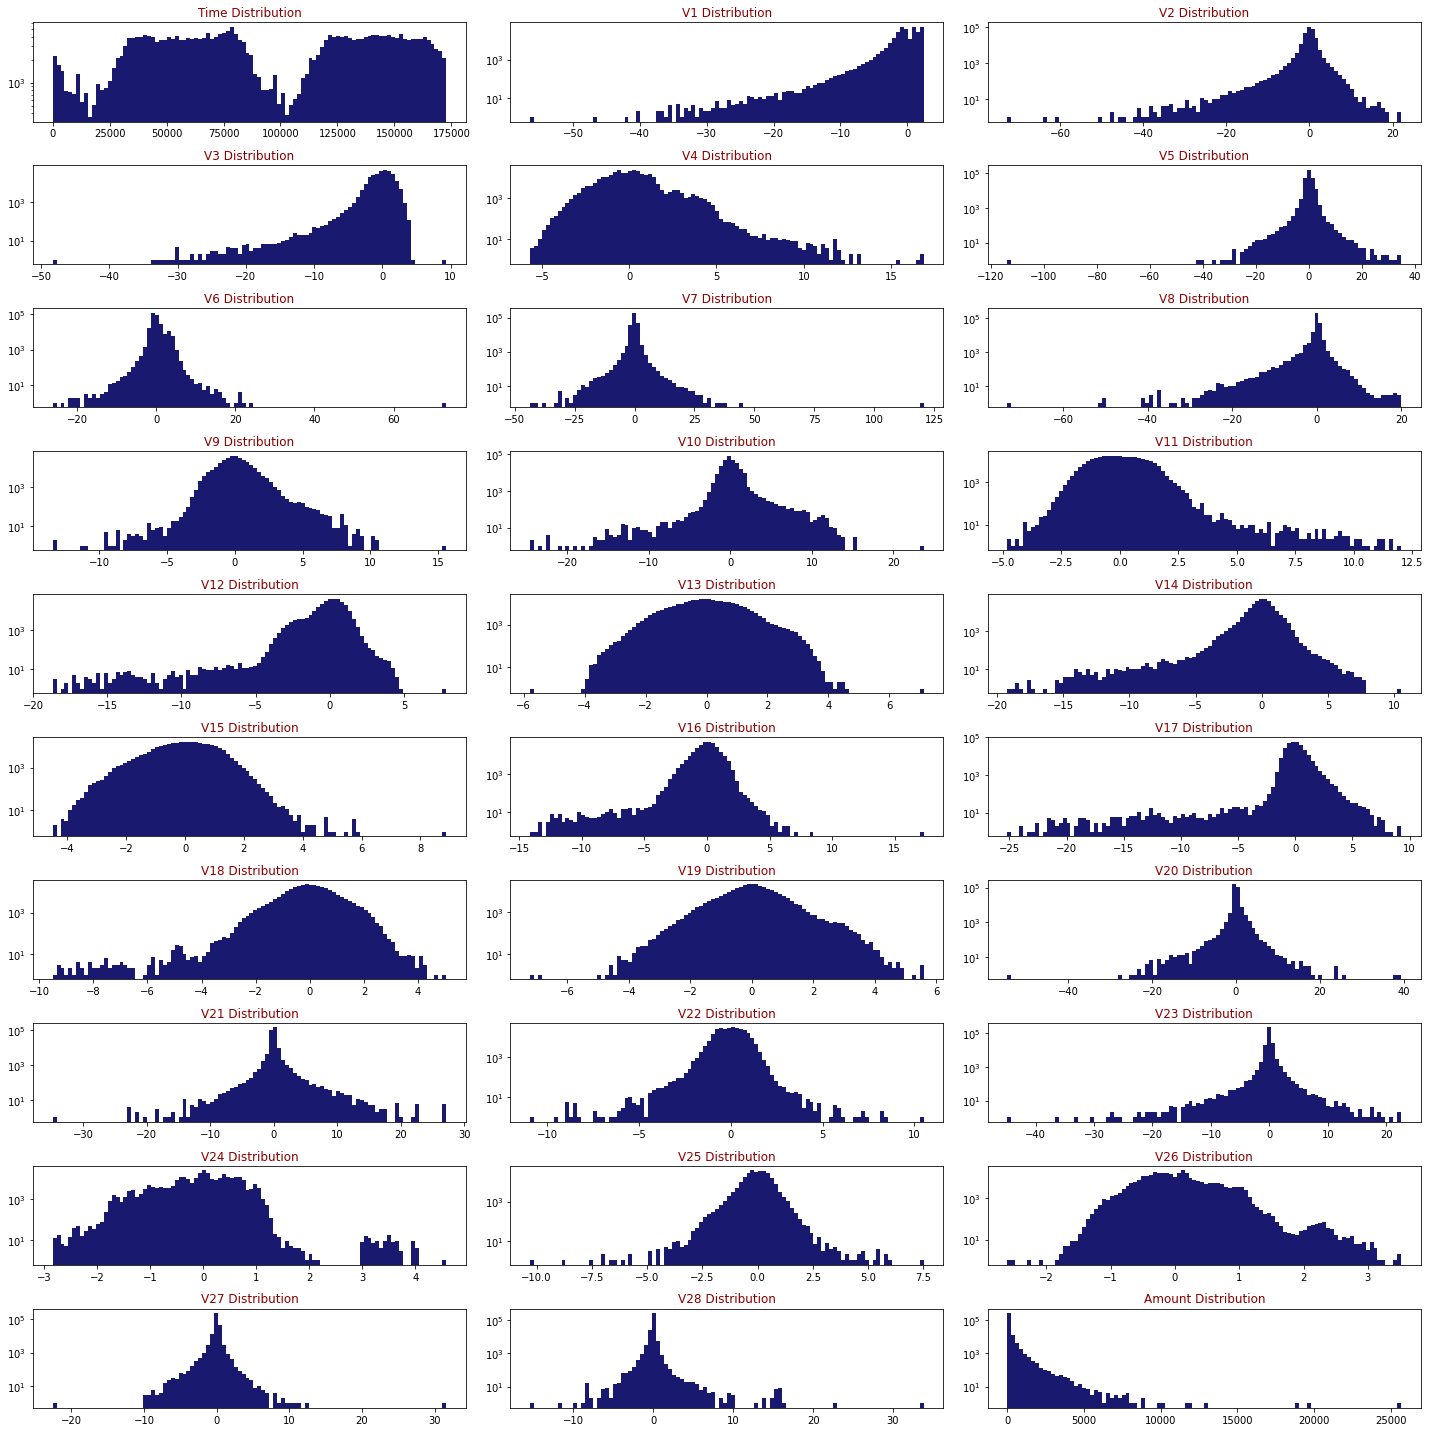

In [13]:
def draw_histograms(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(20,20))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].hist(bins=100,ax=ax,facecolor='midnightblue')
        ax.set_title(feature+" Distribution",color='DarkRed')
        ax.set_yscale('log')
        ax.grid(False)
    fig.tight_layout()  
    plt.show()
draw_histograms(df,df.drop('Class', axis=1).columns,10,3)

Se graficó en escala logarítmica en y para lograr observar los valores pequeños. Para la variable del tiempo se obtiene una distribución correspondiente a una serie de tiempo de periodo de un día. Es altamente probable que los valles correspondan a las horas de la madrugada, cuando se realizan considerablemente menos transacciones. Por el lado del monto, se observa un comportamiento cercano a una ley de potencias (como en la ley de Zipf o el principio de Pareto), como de alguna manera se espera. 

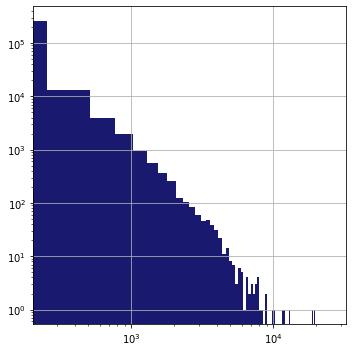

In [11]:
fig=plt.figure(figsize=(5,5))
ax=fig.add_subplot(1,1,1)
df["Amount"].hist(bins=100,ax=ax,facecolor='midnightblue')
ax.set_yscale('log')
ax.set_xscale('log')
fig.tight_layout()  
plt.show()

Vemos ahora la correlación entre nuestras variables:

Text(0.5, 1.0, 'Heatmap of Correlation')

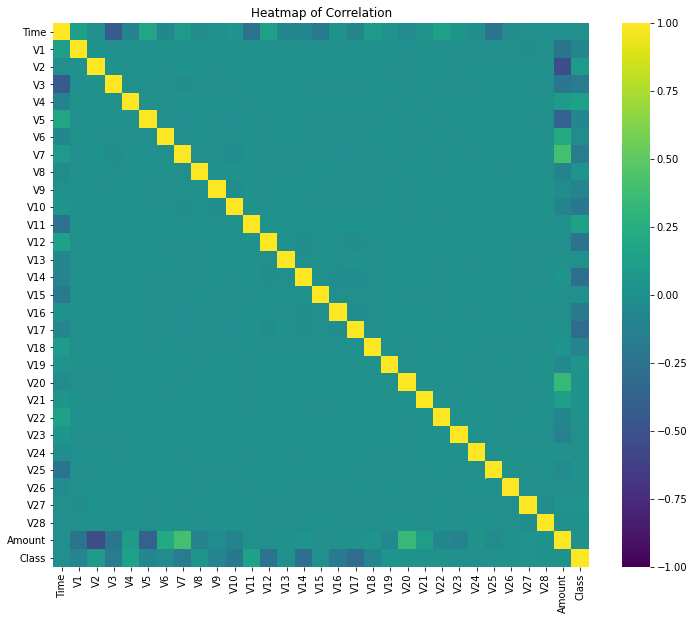

In [12]:
corr = df.corr()
plt.figure(figsize=(12,10))
heat = sns.heatmap(data=corr,vmin=-1.0,vmax=1.0,cmap="viridis")
plt.title('Heatmap of Correlation')

Como es de esperarse, por construcción, la correlación es cercana a cero entre los features del PCA, entonces lo realmente interesante sería observar las otras columnas. Se observa una anticorrelación interesante entre "Amount" y el V2 y un poco el V5 también. También hay una ligera anticorrelación entre "Time" y V3.

### Data Splitting

Ahora separamos nuestro conjuntos entre fraude y no-fraude o normal y y re-escalamos usando la desviación estándar las variables que no han sido re-escaladas mediante el PCA, es decir las corresponientes a "Time" y "Amount". Luego construimos nuestro primer autoencoder. Procedemos a distribuir los datos de la clase normal entre entrenamiento y validación, y la clase de fraude entre una clase de validación y prueba. 

Usaremos los mismo Callbacks que se aplicaron en el primer problema, a saber "Early Stopping" y "Tensorboard".

In [13]:
x = df.drop(["Class"], axis=1)
y = df["Class"].values

x_scale = x.copy()
x_scale['Time'] = StandardScaler().fit_transform(x_scale['Time'].values.reshape(-1, 1))
x_scale['Amount'] = StandardScaler().fit_transform(x_scale['Amount'].values.reshape(-1, 1))

#x_scale = preprocessing.MinMaxScaler().fit_transform(x.values)
x_normal, x_fraude = x_scale[y == 0], x_scale[y == 1]

X_train, X_val, __, __ = train_test_split(x_normal, np.ones((x_normal.shape)[0]), test_size=0.2, random_state=48)
x_fraude,x_fraude_test , __, __ = train_test_split(x_fraude, np.ones((x_fraude.shape)[0]), test_size=0.2, random_state=48)



In [14]:
early_stopping = EarlyStopping(monitor='loss', patience=3, verbose=1, mode='auto', baseline=None, restore_best_weights=False)
tensorboard_callback = TensorBoard(log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), histogram_freq=0, write_graph=True, write_images=False, update_freq='epoch', profile_batch=2, embeddings_freq=0, embeddings_metadata=None,)
callbacks = [early_stopping,tensorboard_callback]

Construiremos nuestros autoencoders usando una arquitectura que va reduciendo paulatinamente el número de neuronas, pasando de 30 a 16 y luego a 8 (capa latente), para luego aumentar de nuevo a 16 y 30, cuando reconstruye la entrada. Primeramente exploraremos activación de tangente hiperbólica para las capas ocultas intermedias con activación ReLu para la capa latente y la capa de salida. También probaremos exclusivamente activación ReLu que finaliza con función sigmoide para la capa de salida.

In [15]:
input = (x_normal.shape)[1]

autoencoder = Sequential(name="Autoencoder")

#Encoder
autoencoder.add(Dense(30, activation='tanh', input_dim = input)) 
autoencoder.add(Dense(16, activation='tanh'))
autoencoder.add(Dense(8, activation='relu'))

#Decoder
autoencoder.add(Dense(16, activation='tanh'))
autoencoder.add(Dense(30, activation='tanh'))
autoencoder.add(Dense(input, activation='relu'))


autoencoder.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(lr=0.001))
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                930       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                496       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_4 (Dense)              (None, 30)                510       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                930       
Total params: 3,146
Trainable params: 3,146
Non-trainable params: 0
_____________________________________________________

In [16]:
autoencoder.fit(X_train, X_train, 
                batch_size = 2048, epochs = 100, 
                shuffle = True, validation_split = 0.20, callbacks=callbacks)

Epoch 1/100
89/89 [==============================] - 6s 63ms/step - loss: 1.0177 - val_loss: 0.8860
Epoch 2/100
89/89 [==============================] - 7s 82ms/step - loss: 0.8741 - val_loss: 0.8087
Epoch 3/100
89/89 [==============================] - 9s 96ms/step - loss: 0.7926 - val_loss: 0.7763
Epoch 4/100
89/89 [==============================] - 9s 97ms/step - loss: 0.7828 - val_loss: 0.7520
Epoch 5/100
89/89 [==============================] - 7s 82ms/step - loss: 0.7631 - val_loss: 0.7304
Epoch 6/100
89/89 [==============================] - 7s 76ms/step - loss: 0.7279 - val_loss: 0.7155
Epoch 7/100
89/89 [==============================] - 7s 80ms/step - loss: 0.7474 - val_loss: 0.7066
Epoch 8/100
89/89 [==============================] - 7s 78ms/step - loss: 0.7033 - val_loss: 0.6998
Epoch 9/100
89/89 [==============================] - 4s 50ms/step - loss: 0.7076 - val_loss: 0.6944
Epoch 10/100
89/89 [==============================] - 6s 64ms/step - loss: 0.7404 - val_loss: 0.6896

In [17]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])

norm_hid_rep = hidden_representation.predict(X_train)
norm_val_hid_rep = hidden_representation.predict(X_val)
fraud_hid_rep = hidden_representation.predict(x_fraude)



In [18]:
norm_train_recons=autoencoder.predict(X_train)
norm_val_recons=autoencoder.predict(X_val)
fraud_recons=autoencoder.predict(x_fraude)

In [19]:
mse_train = (np.square(norm_train_recons - X_train))
mse_val = (np.square(norm_val_recons - X_val))
mse_fraud = (np.square(fraud_recons - x_fraude))

Para observar la capacidad del autoencoder de reconstruir los features, obervamos la distribución del error cuadrático para cada componente. 

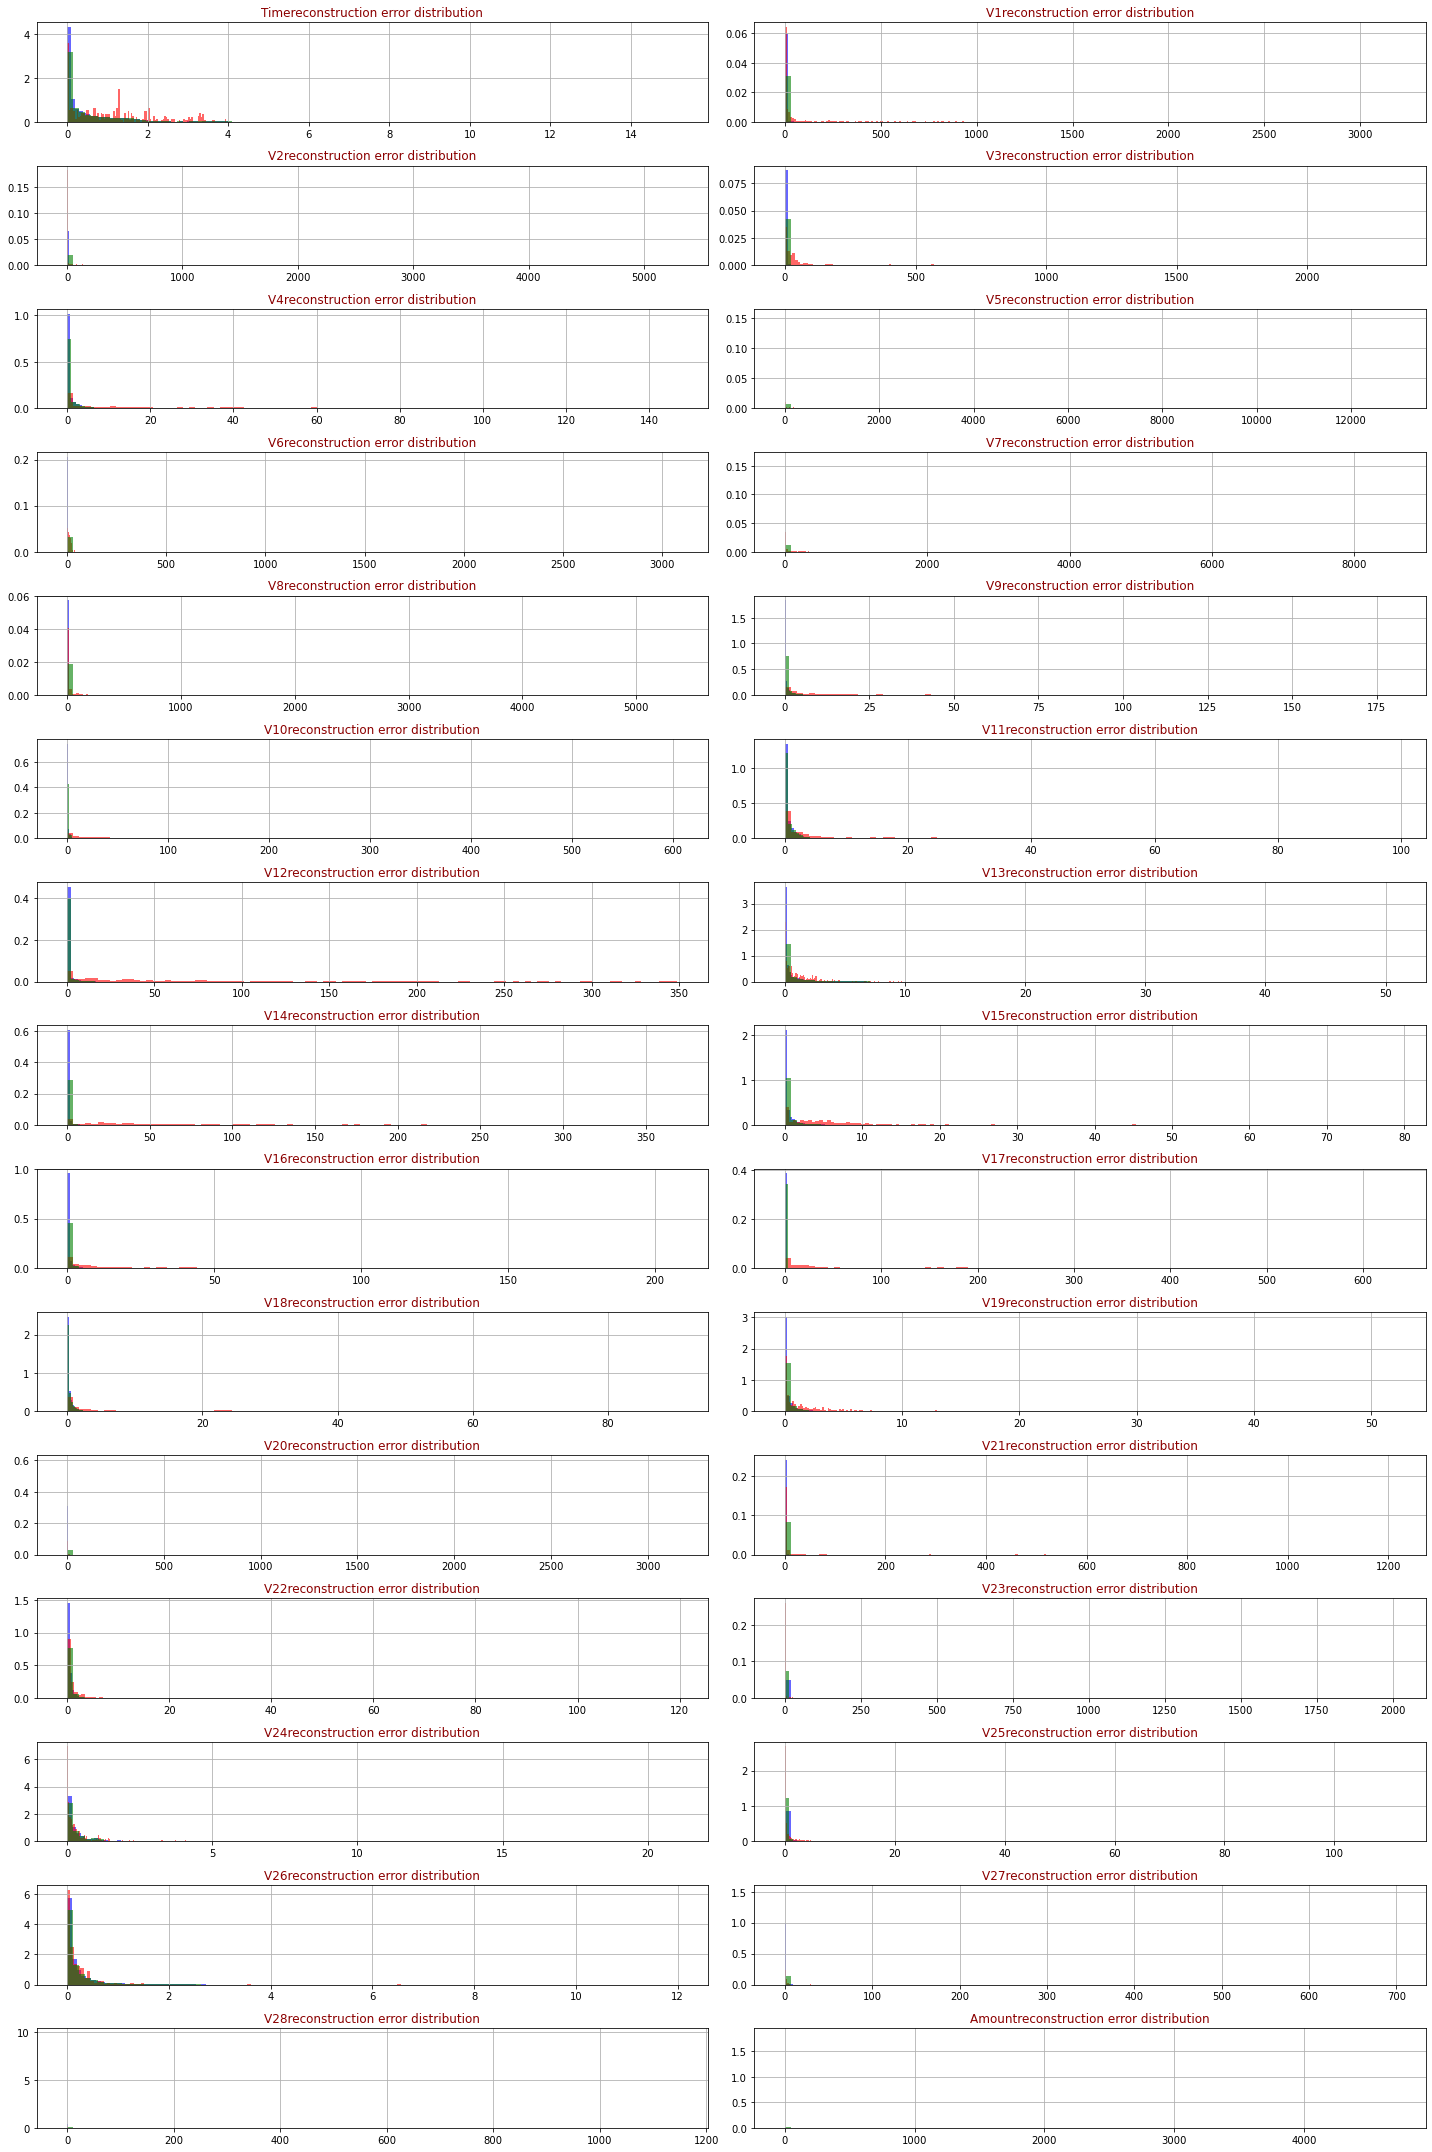

In [21]:
df_mse_train = pd.DataFrame(mse_train, columns = df.drop('Class', axis=1).columns)
df_mse_val = pd.DataFrame(mse_val, columns = df.drop('Class', axis=1).columns)
df_mse_fraud = pd.DataFrame(mse_fraud, columns = df.drop('Class', axis=1).columns)

def draw_3_histograms(dataframe1, dataframe2, dataframe3, features, rows, cols):
    fig=plt.figure(figsize=(20,30))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe1[feature].hist(bins=100,ax=ax,facecolor='blue',alpha=0.6,density=True)
        dataframe2[feature].hist(bins=100,ax=ax,facecolor='red',alpha=0.6,density=True)
        dataframe3[feature].hist(bins=100,ax=ax,facecolor='green',alpha=0.6,density=True)
        ax.set_title(feature+"reconstruction error distribution",color='DarkRed')
        #ax.set_yscale('log')
    fig.tight_layout()  
    plt.show()

draw_3_histograms(df_mse_val, df_mse_fraud, df_mse_train,df.drop('Class', axis=1).columns,15,2)

Vemos que en general pareciera que el autoencoder reconstruye mejor los componentes para la clase normal, como se espera, o al menos no es peor para la clase mayoritaria. Vemos entonces la distribución del error cuadrático total sobre el conjunto de entrenamiento y validación de la clase mayoritaria (verde y azul respectivamente) y el conjunto de validación de la clase de fraude (en rojo).

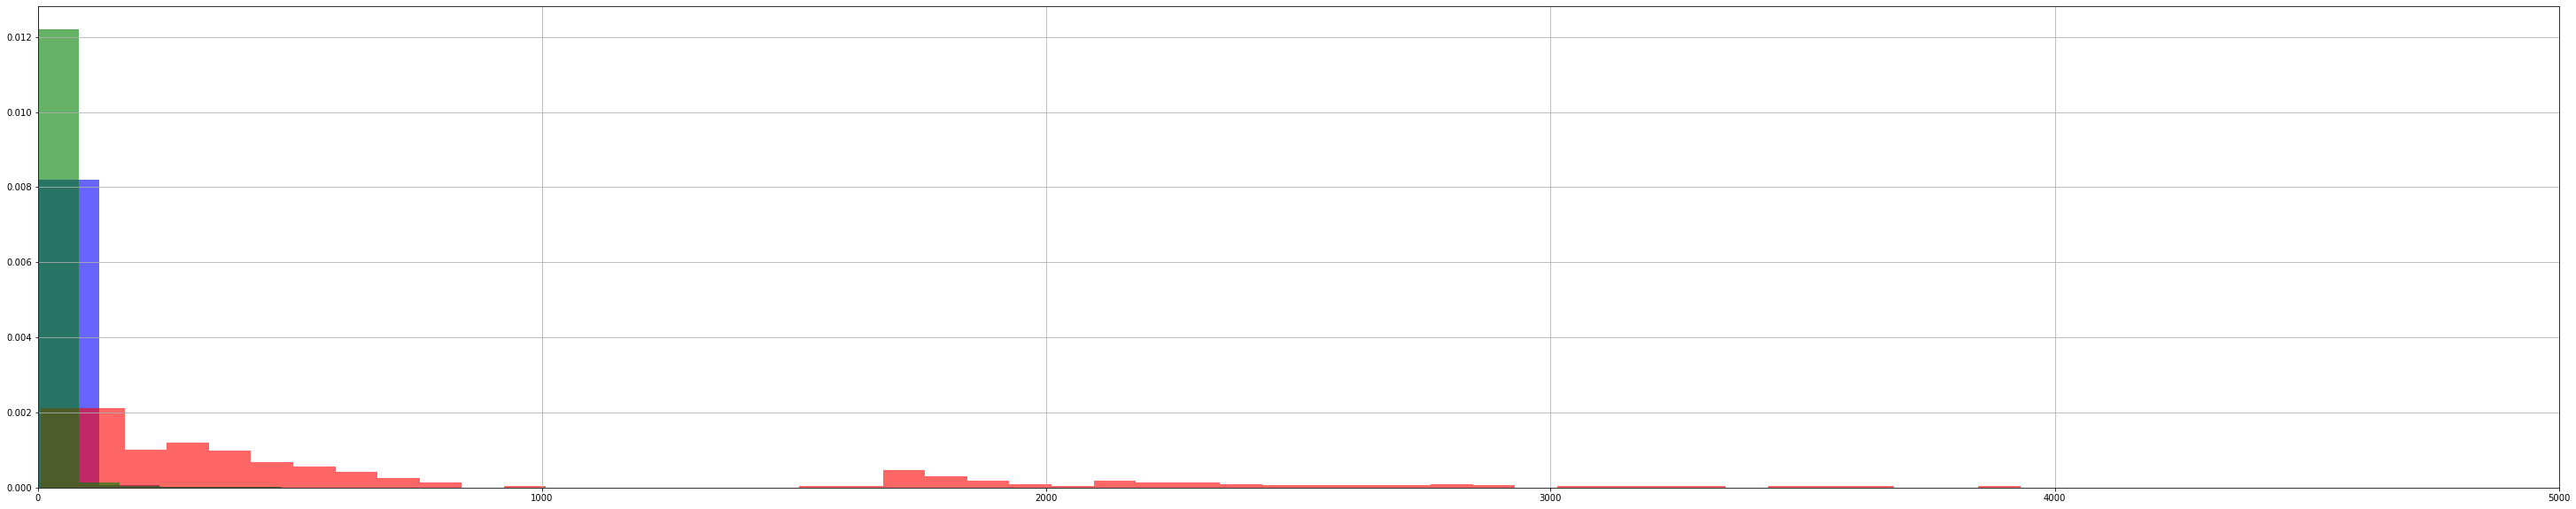

In [22]:
fig=plt.figure(figsize=(51,10))
ax=fig.add_subplot(1,1,1)
df_mse_val.sum(axis=1).hist(bins=40,ax=ax,facecolor='blue',alpha=0.6,density=True)
df_mse_fraud.sum(axis=1).hist(bins=100,ax=ax,facecolor='red',alpha=0.6,density=True)
df_mse_train.sum(axis=1).hist(bins=500,ax=ax,facecolor='green',alpha=0.6,density=True)
plt.xlim(0,5000)
plt.show()

Efectivamente el autoencoder reconstruye los datos de la clase mayoritaria con mucho menos error en general. Probamos ahora la segunda elección para funciones de activación.

In [23]:
input = (x_normal.shape)[1]

autoencoder2 = Sequential(name="Autoencoder2")

#Encoder
autoencoder2.add(Dense(30, activation='relu', input_dim = input)) #, activity_regularizer=regularizers.l1(10e-5)))
autoencoder2.add(Dense(16, activation='relu'))
autoencoder2.add(Dense(8, activation='relu'))

#Decoder
autoencoder2.add(Dense(16, activation='relu'))
autoencoder2.add(Dense(30, activation='relu'))
autoencoder2.add(Dense(input, activation='relu'))


autoencoder2.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(lr=0.001))
autoencoder2.summary()

autoencoder2.fit(X_train, X_train, 
                batch_size = 2048, epochs = 100, 
                shuffle = True, validation_split = 0.20, callbacks=callbacks)

Model: "Autoencoder2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_7 (Dense)              (None, 16)                496       
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_10 (Dense)             (None, 30)                510       
_________________________________________________________________
dense_11 (Dense)             (None, 30)                930       
Total params: 3,146
Trainable params: 3,146
Non-trainable params: 0
____________________________________________________

Epoch 71/100
89/89 [==============================] - 7s 77ms/step - loss: 0.6933 - val_loss: 0.6854
Epoch 72/100
89/89 [==============================] - 4s 47ms/step - loss: 0.6924 - val_loss: 0.6858
Epoch 73/100
89/89 [==============================] - 5s 59ms/step - loss: 0.7000 - val_loss: 0.6852
Epoch 74/100
89/89 [==============================] - 6s 72ms/step - loss: 0.6901 - val_loss: 0.6858
Epoch 75/100
89/89 [==============================] - 5s 52ms/step - loss: 0.6983 - val_loss: 0.6848
Epoch 76/100
89/89 [==============================] - 5s 57ms/step - loss: 0.6947 - val_loss: 0.6848
Epoch 77/100
89/89 [==============================] - 4s 40ms/step - loss: 0.6948 - val_loss: 0.6846
Epoch 78/100
89/89 [==============================] - 5s 60ms/step - loss: 0.7075 - val_loss: 0.6845
Epoch 79/100
89/89 [==============================] - 5s 52ms/step - loss: 0.7116 - val_loss: 0.6844
Epoch 80/100
89/89 [==============================] - 6s 64ms/step - loss: 0.7082 - val_los

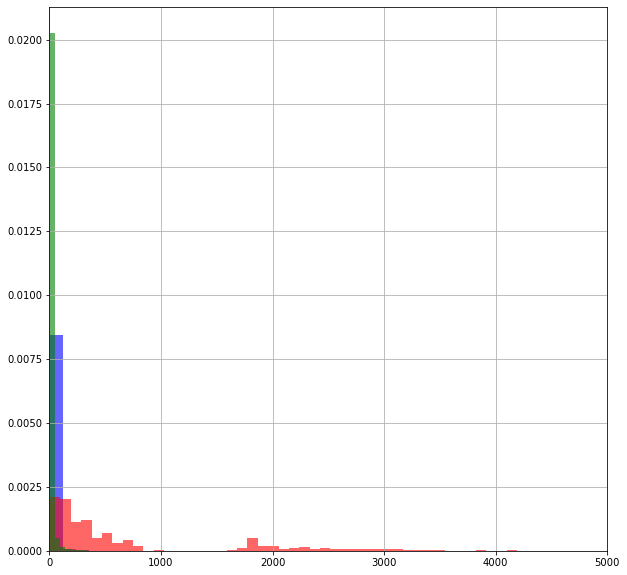

In [24]:
norm_train_recons=autoencoder2.predict(X_train)
norm_val_recons=autoencoder2.predict(X_val)
fraud_recons=autoencoder2.predict(x_fraude)

mse_train = (np.square(norm_train_recons - X_train))
mse_val = (np.square(norm_val_recons - X_val))
mse_fraud = (np.square(fraud_recons - x_fraude))

fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(1,1,1)
mse_val.sum(axis=1).hist(bins=40,ax=ax,facecolor='blue',alpha=0.6,density=True)
mse_fraud.sum(axis=1).hist(bins=100,ax=ax,facecolor='red',alpha=0.6,density=True)
mse_train.sum(axis=1).hist(bins=500,ax=ax,facecolor='green',alpha=0.6,density=True)
plt.xlim(0,5000)
plt.show()

Calculamos ahora qué porcentaje de datos fraudulentos se escaparían para el primer modelo, si permitimos que hasta el 2% de las transacciones legítimas sean clasificadas erróneamente como fraudulentas (falsos positivos), y posteriormente hacemos lo mismo para el segundo modelo.

In [25]:
percentileofscore(df_mse_fraud.sum(axis=1), np.percentile(df_mse_train.sum(axis=1),98, interpolation="linear"), kind="mean") 

17.391304347826086

In [26]:
percentileofscore(mse_fraud.sum(axis=1), np.percentile(mse_train.sum(axis=1),98, interpolation="linear"), kind="mean") 

19.021739130434785

Elegimos entonces el primer modelo, y evaluando en el conjunto de prueba, nos reporta que el modelo no es capaz de capturar 

In [28]:
df_fraud_recons_test=autoencoder.predict(x_fraude_test)
df_mse_fraud_test = (np.square(df_fraud_recons_test - x_fraude_test))

In [29]:
percentileofscore(df_mse_fraud_test.sum(axis=1), np.percentile(df_mse_train.sum(axis=1),98, interpolation="linear"), kind="mean") 

19.565217391304348